<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #ffaa30;
            background-color:#317900;
            color: white;
            overflow:hidden;
            font-weight:500"><strong>SriOryzaugur:</strong> ARIMAX, SARIMAX, ARIMA, SARIMA</div>

\begin{equation}
\mathrm{SARIMA}(p, d, q) \times (P, D, Q, S)
\end{equation}

\begin{equation}
\mathrm{ARIMA}(p, d, q)
\end{equation}

# **1. Install Packages 📥** <a class='anchor' id='packages'></a> [↑](#top)

In [269]:
!pip install pmdarima

# **2. Import Packages 📩** <a class='anchor' id='import'></a> [↑](#top)

In [270]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.style.use("bmh")

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# **3. Loading Dataset and Feature Engineering 🔬** <a class='anchor' id='feature_engineering'></a> [↑](#top)

In [271]:
df = pd.read_csv('/kaggle/input/sri-oryzaugur-dataset/imputed_processed_data.csv',
                 index_col = "date", 
                 parse_dates = True)

df = df[(df.index < pd.to_datetime("2020-01-01"))]
df.head()

,price,anuradhapura_producer_price,kurunegala_producer_price,polonnaruwa_producer_price,production,production_total,exchange_rate,fuel_price,m0,m2,m1,m2b
date,,,,,,,,,,,,
1996-01-01,18.07,7.75,7.90,8.18,1333.6,2065.1,53.685,12.4,77071,228090,73783,260481
1996-02-01,18.70,8.17,8.26,8.76,1333.6,2065.1,53.685,12.4,79586,234199,77440,269496
1996-03-01,18.49,7.95,7.85,7.99,1333.6,2065.1,53.685,12.4,82915,239178,81796,272552
1996-04-01,18.52,8.25,8.01,8.29,1333.6,2065.1,54.735,12.4,80873,241893,79478,278425
1996-05-01,19.02,8.38,8.50,8.34,731.5,2065.1,54.950,12.4,83410,242072,76620,277365


In [272]:
df = df.loc[:,  ['price', 'anuradhapura_producer_price', 'kurunegala_producer_price', 'polonnaruwa_producer_price', 'exchange_rate', 'm1']]
df.head(1)                       

,price,anuradhapura_producer_price,kurunegala_producer_price,polonnaruwa_producer_price,exchange_rate,m1
date,,,,,,
1996-01-01,18.07,7.75,7.9,8.18,53.685,73783


In [273]:
original_df = df.copy()

In [274]:
avgs = df.mean()
devs = df.std()

print(avgs)
print(devs)

for col in df.columns:
    df[col] = (df[col] - avgs.loc[col]) / devs.loc[col]
    
original_df_standard = df.copy()    
df

price                              51.705174
anuradhapura_producer_price        23.118160
kurunegala_producer_price          23.603467
polonnaruwa_producer_price         23.464080
exchange_rate                     109.999514
m1                             343322.715278
dtype: float64
price                              25.332963
anuradhapura_producer_price        12.463182
kurunegala_producer_price          12.679100
polonnaruwa_producer_price         12.710677
exchange_rate                      31.631340
m1                             244908.400742
dtype: float64


,price,anuradhapura_producer_price,kurunegala_producer_price,polonnaruwa_producer_price,exchange_rate,m1
date,,,,,,
1996-01-01,-1.327724,-1.233085,-1.238532,-1.202460,-1.780339,-1.100574
1996-02-01,-1.302855,-1.199386,-1.210139,-1.156829,-1.780339,-1.085641
1996-03-01,-1.311144,-1.217038,-1.242475,-1.217408,-1.780339,-1.067855
1996-04-01,-1.309960,-1.192967,-1.229856,-1.193806,-1.747144,-1.077320
1996-05-01,-1.290223,-1.182536,-1.191210,-1.189872,-1.740347,-1.088990
...,...,...,...,...,...,...
2019-08-01,1.474554,1.641783,1.577126,1.787546,2.187719,1.938706
2019-09-01,1.593766,1.795837,1.817994,2.058578,2.276239,2.040548
2019-10-01,1.777717,2.155296,2.058863,2.190750,2.246205,1.907951


# **4. Check Staionarity 📏**

In [275]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [276]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.1389
 No. Lags Chosen       = 11
 Critical value 1%     = -3.454
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.9454. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "anuradhapura_producer_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.3533
 No. Lags Chosen       = 15
 Critical value 1%     = -3.455
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.9176. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "kurunegala_producer_price" 
    -----------------------------------

In [277]:
df = df.diff().dropna()

for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.7434
 No. Lags Chosen       = 10
 Critical value 1%     = -3.454
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "anuradhapura_producer_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9059
 No. Lags Chosen       = 14
 Critical value 1%     = -3.455
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "kurunegala_producer_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit ro

In [278]:
df = df.diff().dropna()

for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.959
 No. Lags Chosen       = 10
 Critical value 1%     = -3.454
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "anuradhapura_producer_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.5394
 No. Lags Chosen       = 13
 Critical value 1%     = -3.455
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "kurunegala_producer_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. 

<br></br>
**After differencing twice, all the series become Stationary. We now have to get the lowest AIC for the SARIMAX model, below we are going to be doing a stepwise search with a monthly seasonality.**

# **5. Get Lowest AIC 🅰️ℹ️©️**

In [284]:
from pmdarima import auto_arima

In [279]:
auto_arima(df['price'], m=12, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-488.856, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-519.528, Time=0.72 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-490.850, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-511.888, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=-525.011, Time=3.26 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=5.61 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=-490.517, Time=1.37 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=-532.651, Time=3.28 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=-527.070, Time=1.64 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=5.50 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.46 sec
 ARIMA(3,0,0)(2,0,0)[12] intercept   : AIC=-550.8

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  286
Model:             SARIMAX(3, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 315.946
Date:                            Fri, 05 May 2023   AIC                           -615.891
Time:                                    13:27:45   BIC                           -586.643
Sample:                                03-01-1996   HQIC                          -604.168
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.929e-06   1.98e-05     -0.098      0.922   -4.07e-05    3.68e-05
ar.L1          0.3451      0.050      6.917      0.000       0.247       0.443
ar.L2          0.0216      0.045      0.485      0.628      -0.066       0.109
ar.L3         -0.0786      0.039     -1.993      0.046      -0.156      -0.001
ma.L1         -0.9827      0.023    -43.594      0.000      -1.027      -0.939
ar.S.L12       0.9089      0.098      9.285      0.000       0.717       1.101
ma.S.L12      -0.8247      0.143     -5.763      0.000      -1.105      -0.544
sigma2         0.0064      0.000     18.382      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):               665.40
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               4.07   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

> **Getting Lowest AIC without Seasonality**

In [285]:
auto_arima(df['price'], trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-488.856, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-511.888, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-490.850, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-518.018, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-537.532, Time=0.23 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-561.775, Time=0.71 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-560.317, Time=1.01 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-585.892, Time=1.29 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-584.565, Time=1.57 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.68 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  286
Model:               SARIMAX(4, 0, 1)   Log Likelihood                 299.946
Date:                Fri, 05 May 2023   AIC                           -585.892
Time:                        13:37:41   BIC                           -560.300
Sample:                    03-01-1996   HQIC                          -575.634
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.081e-05      0.000      0.039      0.969      -0.001       0.001
ar.L1          0.3632      0.055      6.578      0.000       0.255       0.471
ar.L2         -0.0211      0.043     -0.497      0.619      -0.105       0.062
ar.L3         -0.1079      0.037     -2.903      0.004      -0.181      -0.035
ar.L4          0.0250      0.063      0.398      0.691      -0.098       0.148
ma.L1         -0.9556      0.033    -29.115      0.000      -1.020      -0.891
sigma2         0.0069      0.000     24.269      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               662.26
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               3.82   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# **6. Test Train Split** 🪓 <a class='anchor' id='split'></a> [↑](#top)

In [286]:
horizon = 12
train_df = original_df_standard.iloc[:-horizon, :]
test_df = original_df_standard.iloc[-horizon:, :]

print(train_df.tail(1))
print('\n------------')
print(test_df.tail(1))

               price  anuradhapura_producer_price  kurunegala_producer_price  \
date                                                                           
2018-12-01  1.507713                     1.662644                    1.81902   

            polonnaruwa_producer_price  exchange_rate        m1  
date                                                             
2018-12-01                     1.28731       2.295207  1.990419  

------------
               price  anuradhapura_producer_price  kurunegala_producer_price  \
date                                                                           
2019-12-01  2.036273                      2.52358                   2.353995   

            polonnaruwa_producer_price  exchange_rate        m1  
date                                                             
2019-12-01                    2.444081       2.254109  2.131998  


In [287]:
exog_train = train_df[train_df.columns[1:]]
exog_test = test_df[train_df.columns[1:]]

print(exog_train.tail(1))
print('\n------------')
print(exog_test.tail(1))

            anuradhapura_producer_price  kurunegala_producer_price  \
date                                                                 
2018-12-01                     1.662644                    1.81902   

            polonnaruwa_producer_price  exchange_rate        m1  
date                                                             
2018-12-01                     1.28731       2.295207  1.990419  

------------
            anuradhapura_producer_price  kurunegala_producer_price  \
date                                                                 
2019-12-01                      2.52358                   2.353995   

            polonnaruwa_producer_price  exchange_rate        m1  
date                                                             
2019-12-01                    2.444081       2.254109  2.131998  


In [288]:
start = len(train_df)
end = len(train_df) + len(test_df) - 1

print(start)
print(end)

276
287


# **7. Building and Training the Model 🏗️** <a class='anchor' id='model'></a> [↑](#top)

## **7.1 SARIMAX**

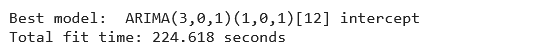

In [289]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarimax = SARIMAX(train_df['price'],
                        order=(3,0,1),
                        seasonal_order=(1,0,1,12),
                        exog=exog_train,
                        enforce_stationarity=True)

res_sarimax = model_sarimax.fit()
res_sarimax.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.73092D-01    |proj g|=  9.20093D-01


 This problem is unconstrained.



At iterate    5    f= -1.02474D+00    |proj g|=  6.70329D-01

At iterate   10    f= -1.13677D+00    |proj g|=  8.66705D-01

At iterate   15    f= -1.15241D+00    |proj g|=  2.87951D-01

At iterate   20    f= -1.18292D+00    |proj g|=  8.16520D-02

At iterate   25    f= -1.20683D+00    |proj g|=  2.68605D-01

At iterate   30    f= -1.21794D+00    |proj g|=  9.44555D-02

At iterate   35    f= -1.23337D+00    |proj g|=  8.30561D-02

At iterate   40    f= -1.23641D+00    |proj g|=  2.56883D-02

At iterate   45    f= -1.23893D+00    |proj g|=  7.49946D-02

At iterate   50    f= -1.23927D+00    |proj g|=  3.50091D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                  276
Model:             SARIMAX(3, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 342.038
Date:                            Fri, 05 May 2023   AIC                           -660.076
Time:                                    13:38:55   BIC                           -616.631
Sample:                                01-01-1996   HQIC                          -642.642
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
anuradhapura_producer_price     0.0896      0.031      2.885      0.004       0.029       0.150
kurunegala_producer_price       0.0482      0.025      1.943      0.052      -0.000       0.097
polonnaruwa_producer_price      0.1284      0.033      3.861      0.000       0.063       0.194
exchange_rate                   0.0312      0.169      0.185      0.853      -0.299       0.362
m1                             -0.2192      0.077     -2.845      0.004      -0.370      -0.068
ar.L1                           0.2000      0.385      0.520      0.603      -0.554       0.954
ar.L2                           0.9841      0.445      2.214      0.027       0.113       1.855
ar.L3                          -0.1842      0.082     -2.249      0.025      -0.345      -0.024
ma.L1                           0.9849      0.385      2.560      0.010       0.231       1.739
ar.S.L12                        0.9573      0.067     14.320      0.000       0.826       1.088
ma.S.L12                       -0.8742      0.127     -6.907      0.000      -1.122      -0.626
sigma2                          0.0046      0.000     14.749      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               460.50
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               4.29   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [290]:
prediction_sarimax = res_sarimax.predict(start, 
                                         end, 
                                         exog=exog_test, 
                                         typ='linear').rename('sarimax_prediction')

In [291]:
forecasts_reversed = prediction_sarimax.to_frame()
forecasts_reversed['sarimax_prediction'] = forecasts_reversed['sarimax_prediction'] * devs['price'] + avgs['price']

forecasts_reversed

,sarimax_prediction
2019-01-01,88.903926
2019-02-01,86.446133
2019-03-01,85.714121
2019-04-01,88.730721
2019-05-01,90.839347
2019-06-01,89.803028
2019-07-01,90.836408
2019-08-01,91.401427
2019-09-01,92.787842
2019-10-01,94.875438


## **7.2 ARIMAX**

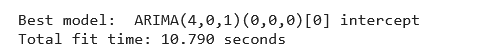

In [292]:
model_arimax = SARIMAX(train_df['price'],
                       order=(4,0,1), 
                       exog=exog_train, 
                       enforce_stationarity=True)

res_arimax = model_arimax.fit()
res_arimax.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.54415D-01    |proj g|=  9.29929D-01

At iterate    5    f= -9.83915D-01    |proj g|=  2.36390D-01

At iterate   10    f= -1.08947D+00    |proj g|=  5.75768D-01

At iterate   15    f= -1.11114D+00    |proj g|=  7.41277D-01

At iterate   20    f= -1.13825D+00    |proj g|=  1.42567D+00

At iterate   25    f= -1.15957D+00    |proj g|=  1.16046D-01

At iterate   30    f= -1.17285D+00    |proj g|=  2.31499D-01

At iterate   35    f= -1.18035D+00    |proj g|=  5.67370D-02

At iterate   40    f= -1.18751D+00    |proj g|=  6.44962D-02

At iterate   45    f= -1.18873D+00    |proj g|=  1.30971D-01

At iterate   50    f= -1.18925D+00    |proj g|=  4.25248D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                  276
Model:               SARIMAX(4, 0, 1)   Log Likelihood                 328.233
Date:                Fri, 05 May 2023   AIC                           -634.467
Time:                        13:40:20   BIC                           -594.642
Sample:                    01-01-1996   HQIC                          -618.486
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
anuradhapura_producer_price     0.0881      0.037      2.411      0.016       0.016       0.160
kurunegala_producer_price       0.0550      0.027      2.008      0.045       0.001       0.109
polonnaruwa_producer_price      0.1089      0.035      3.116      0.002       0.040       0.177
exchange_rate                   0.0984      0.169      0.584      0.559      -0.232       0.429
m1                             -0.2093      0.063     -3.325      0.001      -0.333      -0.086
ar.L1                           0.3062      0.298      1.026      0.305      -0.279       0.891
ar.L2                           0.9150      0.373      2.455      0.014       0.184       1.646
ar.L3                          -0.1790      0.098     -1.824      0.068      -0.371       0.013
ar.L4                          -0.0511      0.050     -1.032      0.302      -0.148       0.046
ma.L1                           0.9099      0.305      2.982      0.003       0.312       1.508
sigma2                          0.0053      0.000     15.648      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               550.03
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               3.97   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [293]:
prediction_arimax = res_arimax.predict(start,
                                       end, 
                                       exog=exog_test, 
                                       typ='linear').rename('arimax_prediction')

In [294]:
forecasts_reversed['arimax_prediction'] = prediction_arimax.to_frame() * devs['price'] + avgs['price']
forecasts_reversed

,sarimax_prediction,arimax_prediction
2019-01-01,88.903926,87.631515
2019-02-01,86.446133,84.406586
2019-03-01,85.714121,84.668468
2019-04-01,88.730721,87.774572
2019-05-01,90.839347,89.523810
2019-06-01,89.803028,88.234926
2019-07-01,90.836408,88.838950
2019-08-01,91.401427,89.555719
2019-09-01,92.787842,90.469108
2019-10-01,94.875438,92.392709


## **7.3 SARIMA**

In [295]:
from statsmodels.tsa.arima.model import ARIMA

model_sarima = ARIMA(train_df['price'],
                     order=(4,0,1),
                     seasonal_order=(1,0,1,12),
                     enforce_stationarity=True)

res_sarima = model_sarima.fit()
res_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            price   No. Observations:                  276
Model:             ARIMA(4, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 310.712
Date:                          Fri, 05 May 2023   AIC                           -603.423
Time:                                  13:40:53   BIC                           -570.840
Sample:                              01-01-1996   HQIC                          -590.348
                                   - 12-01-2018                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0654      2.913     -0.022      0.982      -5.776       5.645
ar.L1          1.1346      0.564      2.010      0.044       0.028       2.241
ar.L2         -0.0566      0.724     -0.078      0.938      -1.475       1.362
ar.L3         -0.1599      0.145     -1.105      0.269      -0.444       0.124
ar.L4          0.0747      0.048      1.555      0.120      -0.019       0.169
ma.L1          0.1634      0.561      0.291      0.771      -0.936       1.262
ar.S.L12       0.9775      0.039     24.988      0.000       0.901       1.054
ma.S.L12      -0.8946      0.097     -9.235      0.000      -1.084      -0.705
sigma2         0.0059      0.000     17.712      0.000       0.005       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               660.02
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               4.03   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [296]:
prediction_sarima = res_sarima.predict(start,
                                       end, 
                                       typ='linear').rename('sarima_prediction')

In [297]:
forecasts_reversed['sarima_prediction'] = prediction_sarima.to_frame() * devs['price'] + avgs['price']
forecasts_reversed

,sarimax_prediction,arimax_prediction,sarima_prediction
2019-01-01,88.903926,87.631515,90.103327
2019-02-01,86.446133,84.406586,89.255424
2019-03-01,85.714121,84.668468,86.824343
2019-04-01,88.730721,87.774572,86.766244
2019-05-01,90.839347,89.523810,87.146701
2019-06-01,89.803028,88.234926,87.013925
2019-07-01,90.836408,88.838950,86.535120
2019-08-01,91.401427,89.555719,85.787638
2019-09-01,92.787842,90.469108,86.132999
2019-10-01,94.875438,92.392709,86.755648


## **7.4 ARIMA**

In [298]:
model_arima = ARIMA(train_df['price'],
                     order=(4,0,1),
                     enforce_stationarity=True)

res_arima = model_arima.fit()
res_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                  276
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 293.274
Date:                Fri, 05 May 2023   AIC                           -572.549
Time:                        13:41:09   BIC                           -547.206
Sample:                    01-01-1996   HQIC                          -562.379
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1833      0.597      0.307      0.759      -0.987       1.354
ar.L1          1.2706      0.339      3.751      0.000       0.607       1.934
ar.L2         -0.2585      0.458     -0.565      0.572      -1.155       0.638
ar.L3         -0.1557      0.143     -1.086      0.277      -0.437       0.125
ar.L4          0.1376      0.038      3.616      0.000       0.063       0.212
ma.L1          0.0961      0.340      0.282      0.778      -0.571       0.763
sigma2         0.0069      0.000     24.181      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               618.75
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               3.28   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [299]:
prediction_arima = res_arima.predict(start,
                                     end, 
                                     typ='linear').rename('arima_prediction')

In [300]:
forecasts_reversed['arima_prediction'] = prediction_arima.to_frame() * devs['price'] + avgs['price']
forecasts_reversed

,sarimax_prediction,arimax_prediction,sarima_prediction,arima_prediction
2019-01-01,88.903926,87.631515,90.103327,89.922732
2019-02-01,86.446133,84.406586,89.255424,90.109535
2019-03-01,85.714121,84.668468,86.824343,89.871348
2019-04-01,88.730721,87.774572,86.766244,89.603562
2019-05-01,90.839347,89.523810,87.146701,89.298919
2019-06-01,89.803028,88.234926,87.013925,89.043863
2019-07-01,90.836408,88.838950,86.535120,88.807469
2019-08-01,91.401427,89.555719,85.787638,88.583634
2019-09-01,92.787842,90.469108,86.132999,88.358138
2019-10-01,94.875438,92.392709,86.755648,88.131202


# **8. Visualize 📊** <a class='anchor' id='visualize'></a> [↑](#top)

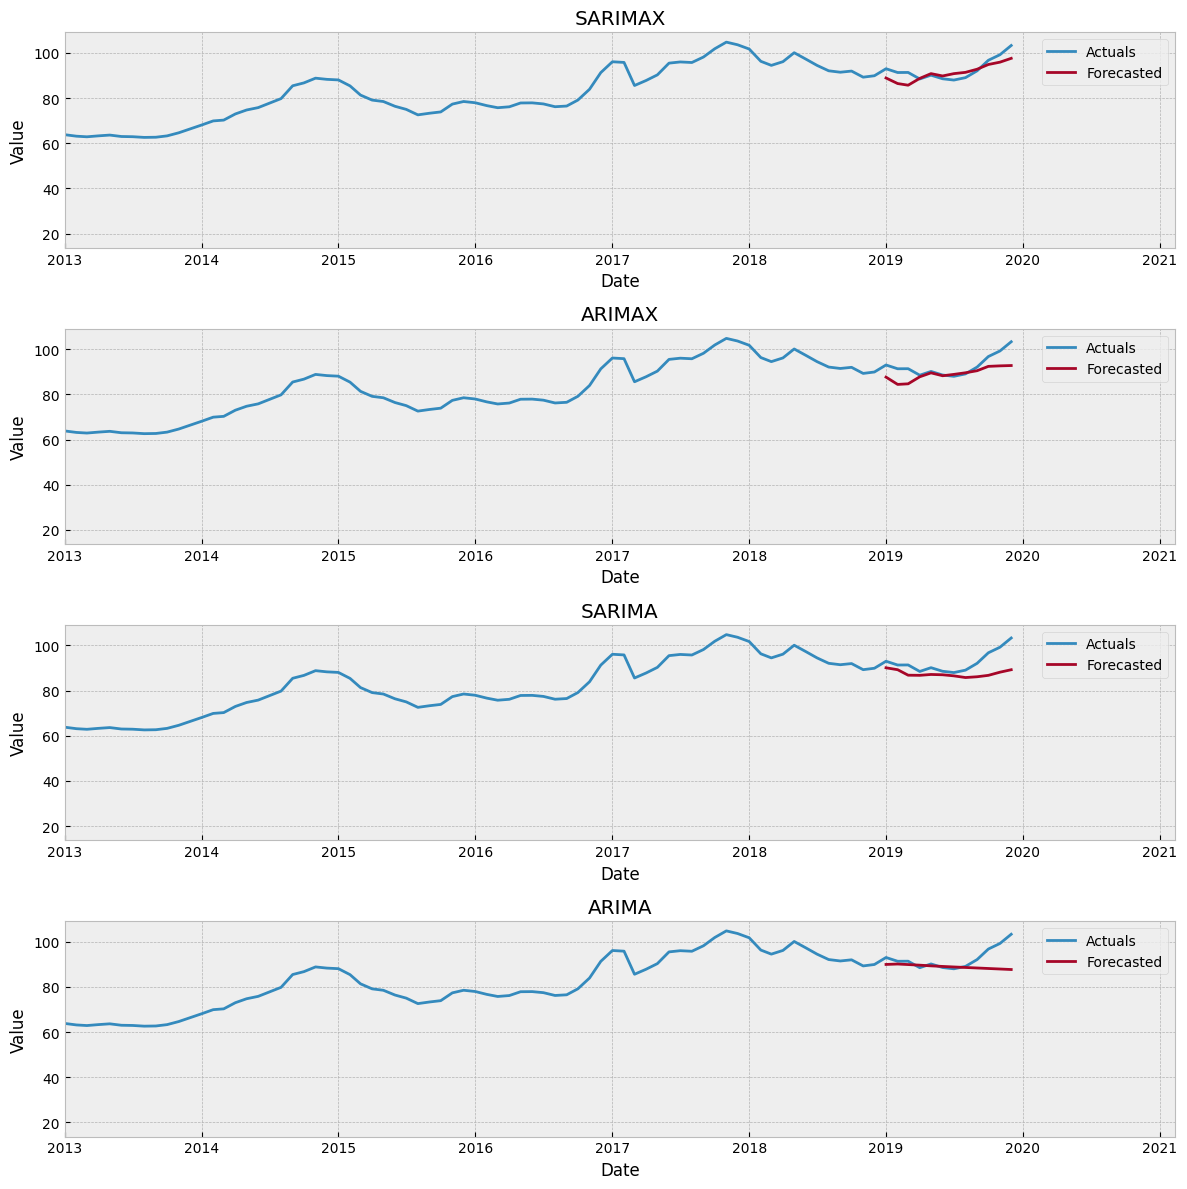

In [301]:
# create a figure and subplots
fig, axs = plt.subplots(4, 1, figsize=(12, 12))

# plot actuals on all subplots
axs[0].plot(original_df.index, original_df['price'], label='Actuals')
axs[1].plot(original_df.index, original_df['price'], label='Actuals')
axs[2].plot(original_df.index, original_df['price'], label='Actuals')
axs[3].plot(original_df.index, original_df['price'], label='Actuals')

# plot SARIMAX on first subplot
axs[0].plot(forecasts_reversed.index, forecasts_reversed['sarimax_prediction'], label='Forecasted')
axs[0].set_title('SARIMAX')
axs[0].legend()

# plot ARIMAX on second subplot
axs[1].plot(forecasts_reversed.index, forecasts_reversed['arimax_prediction'], label='Forecasted')
axs[1].set_title('ARIMAX')
axs[1].legend()

# plot SARIMA on third subplot
axs[2].plot(forecasts_reversed.index, forecasts_reversed['sarima_prediction'], label='Forecasted')
axs[2].set_title('SARIMA')
axs[2].legend()

# plot ARIMA on third subplot
axs[3].plot(forecasts_reversed.index, forecasts_reversed['arima_prediction'], label='Forecasted')
axs[3].set_title('ARIMA')
axs[3].legend()


# add axis labels and set x-axis limits
for ax in axs:
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_xlim(pd.Timestamp('2013-01-01'))

# adjust the subplot layout
plt.tight_layout()

# show the plot
plt.show()

In [303]:
forecasts_reversed.to_csv('sarimax_forecasts.csv', index=True)